In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 1
2023-07-22 13:04:37.630818


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-3.0259)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-3.4609)
penalty_target_min tensor(-11.9806) penalty_target_max tensor(3.1330)
train_loss:  -9.819340663146972
valid_loss:  -9.20669306640625
h_min_tilde -11.980572 ell_tilde -9.69681114379883 kappa_tilde 0.0006617206865259105


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.9073486328125e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 4.267750978469849

 2 3.279757022857666

 3 3.0970916748046875

 4 3.3327393531799316

 5 3.283930540084839

 6 3.214846611022949

 7 3.2472736835479736

 8 3.115795612335205

 9 3.268458604812622

 10 3.262796640396118

 11 3.1379714012145996

 12 3.461703062057495

 13 3.261549234390259

 14 2.9583821296691895

 15 3.1690776348114014

 16 3.210700750350952

 17 3.1774280071258545

 18 3.250931739807129

 19 3.1969504356384277

 20 3.1465494632720947

 21 3.308623790740967

 22 3.2469615936279297

 23 3.1629786491394043

 24 3.2624692916870117

 25 3.1908156871795654

 26 3.207329034805298

 27 3.3180723190307617

 28 3.16202449798584

 29 3.2317707538604736

 30 3.2365007400512695

 31 3.12192702293396

 32 3.1947200298309326

 33 3.307065010070801

 34 3.2705788612365723

 35 3.2253546714782715

 36 3.2246711254119873

 37 3.2839014530181885

 38 3.3113107681274414

 39 3.2514171600341797

 40 3.3237802982330322

 41 3.428480863571167

 42 3.2586679458618164

 43 3.1996054649353

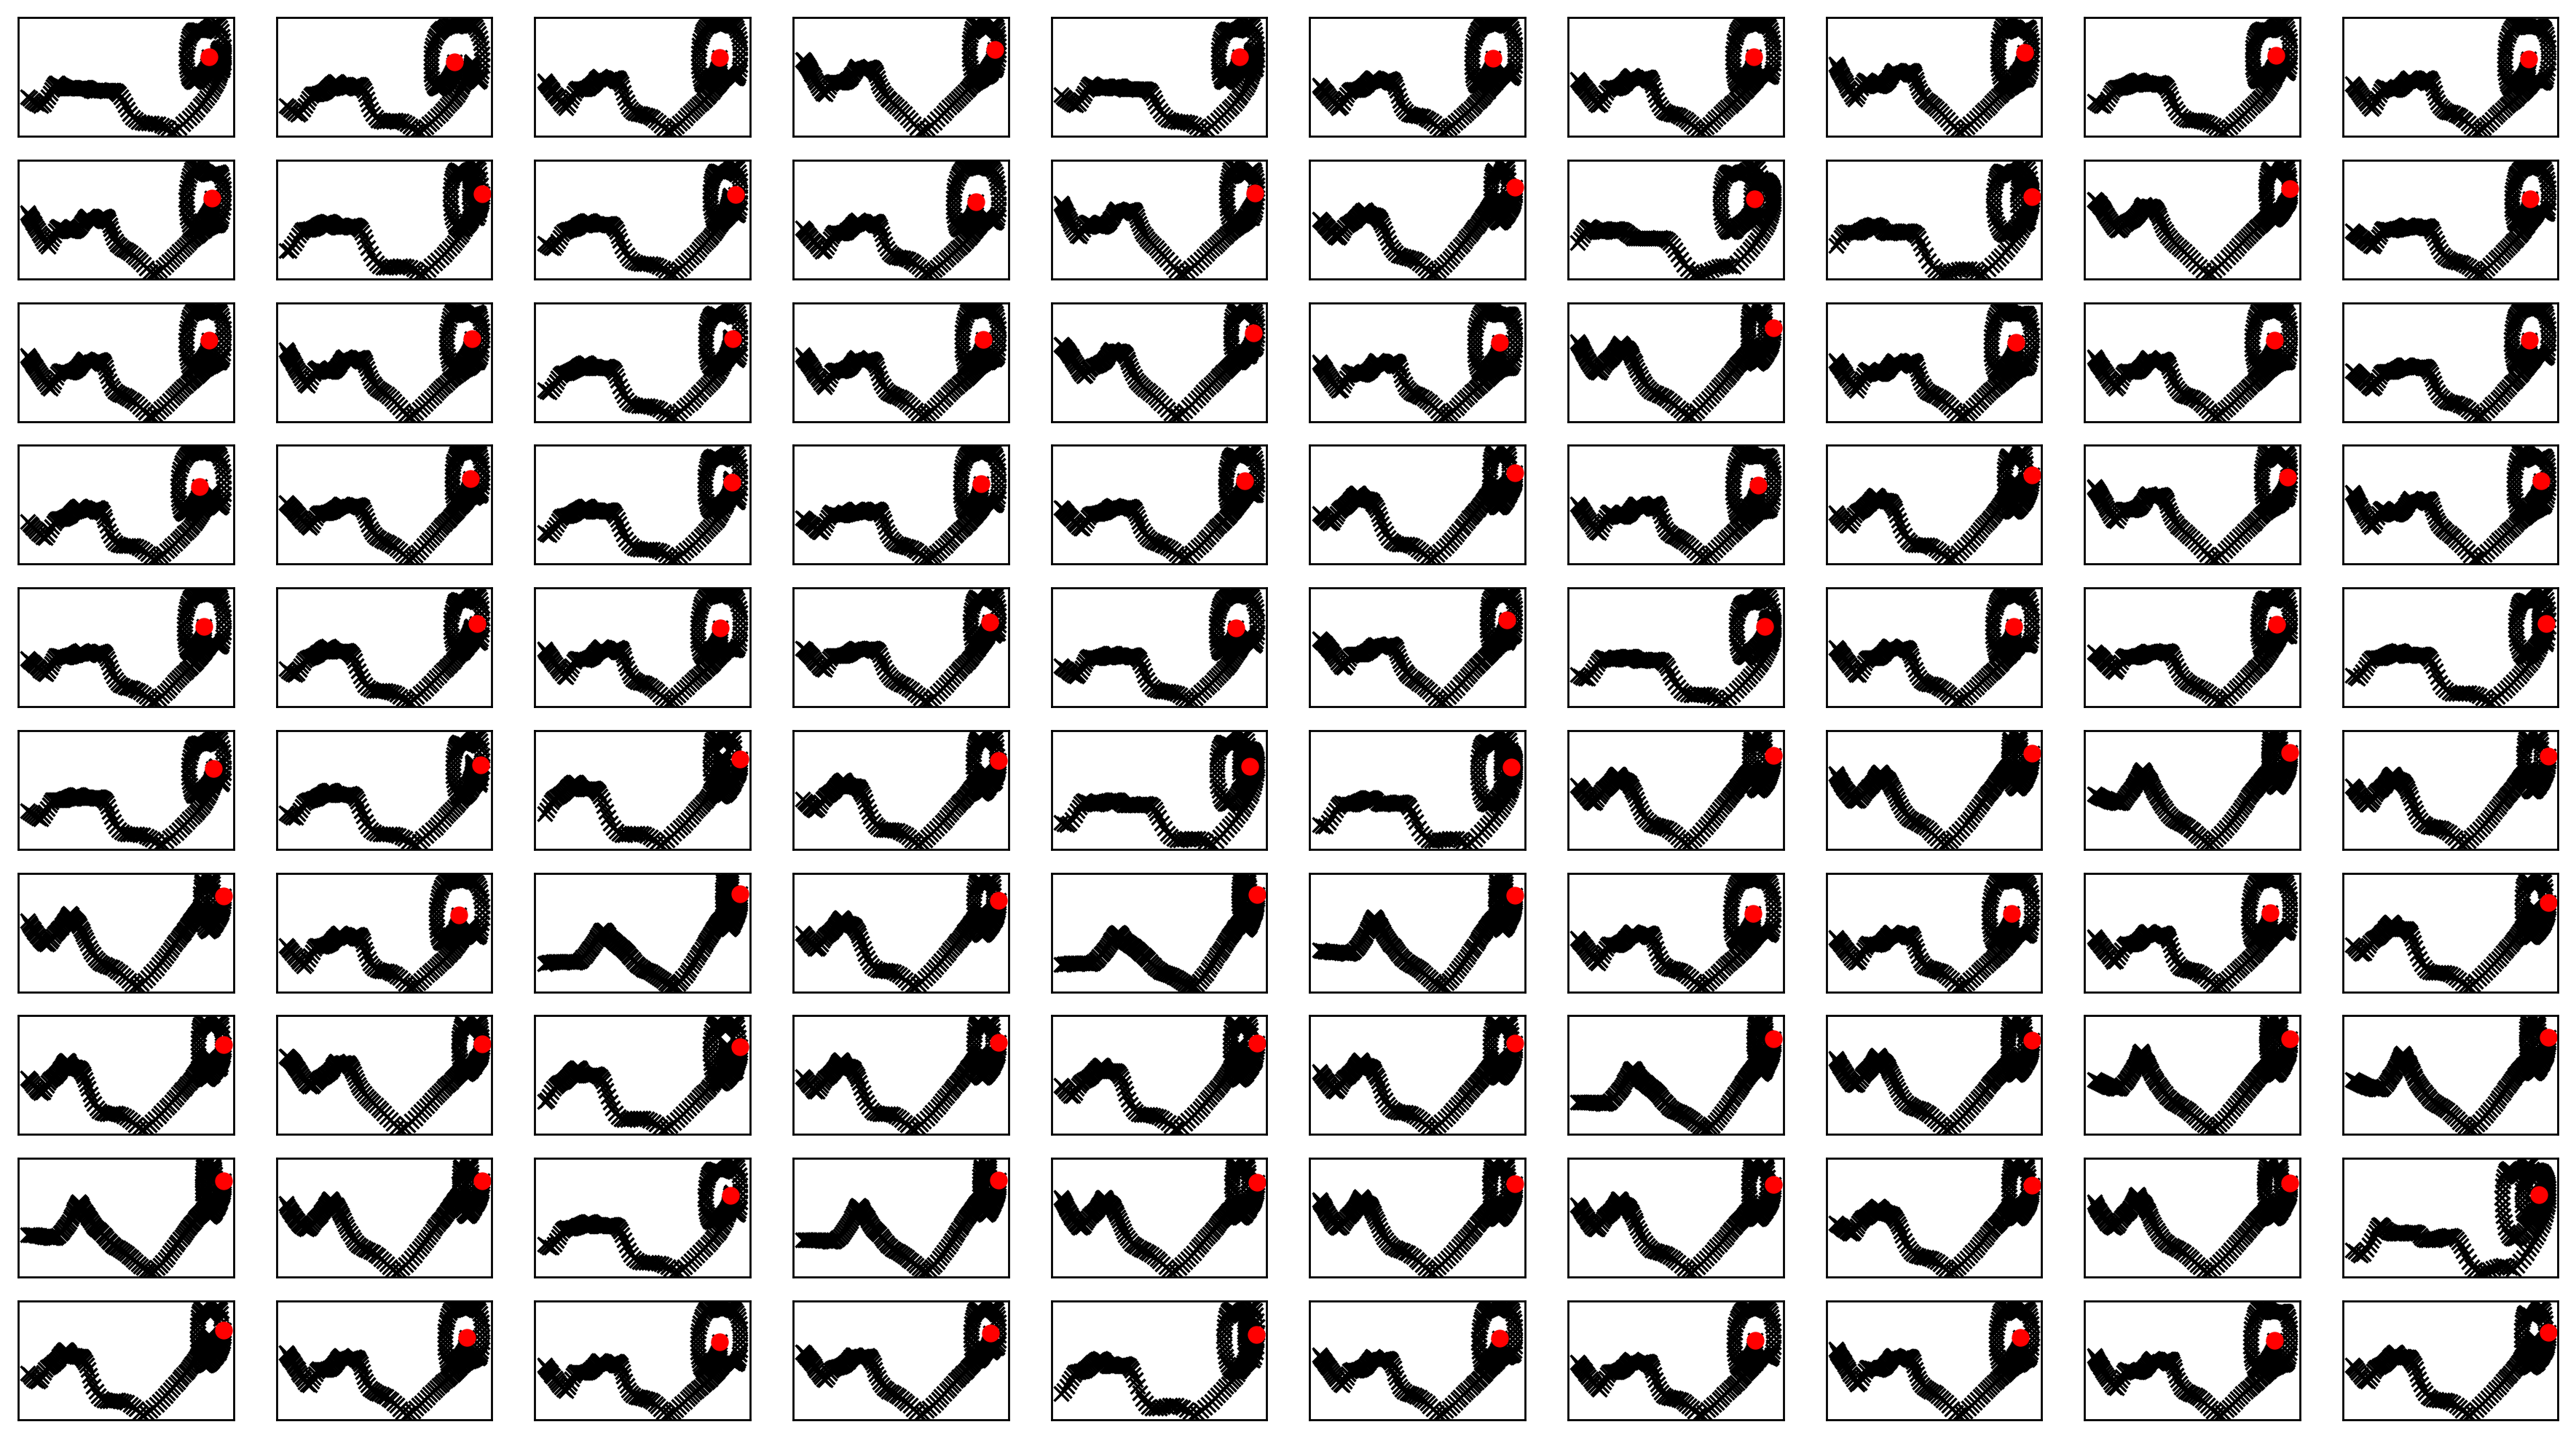

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

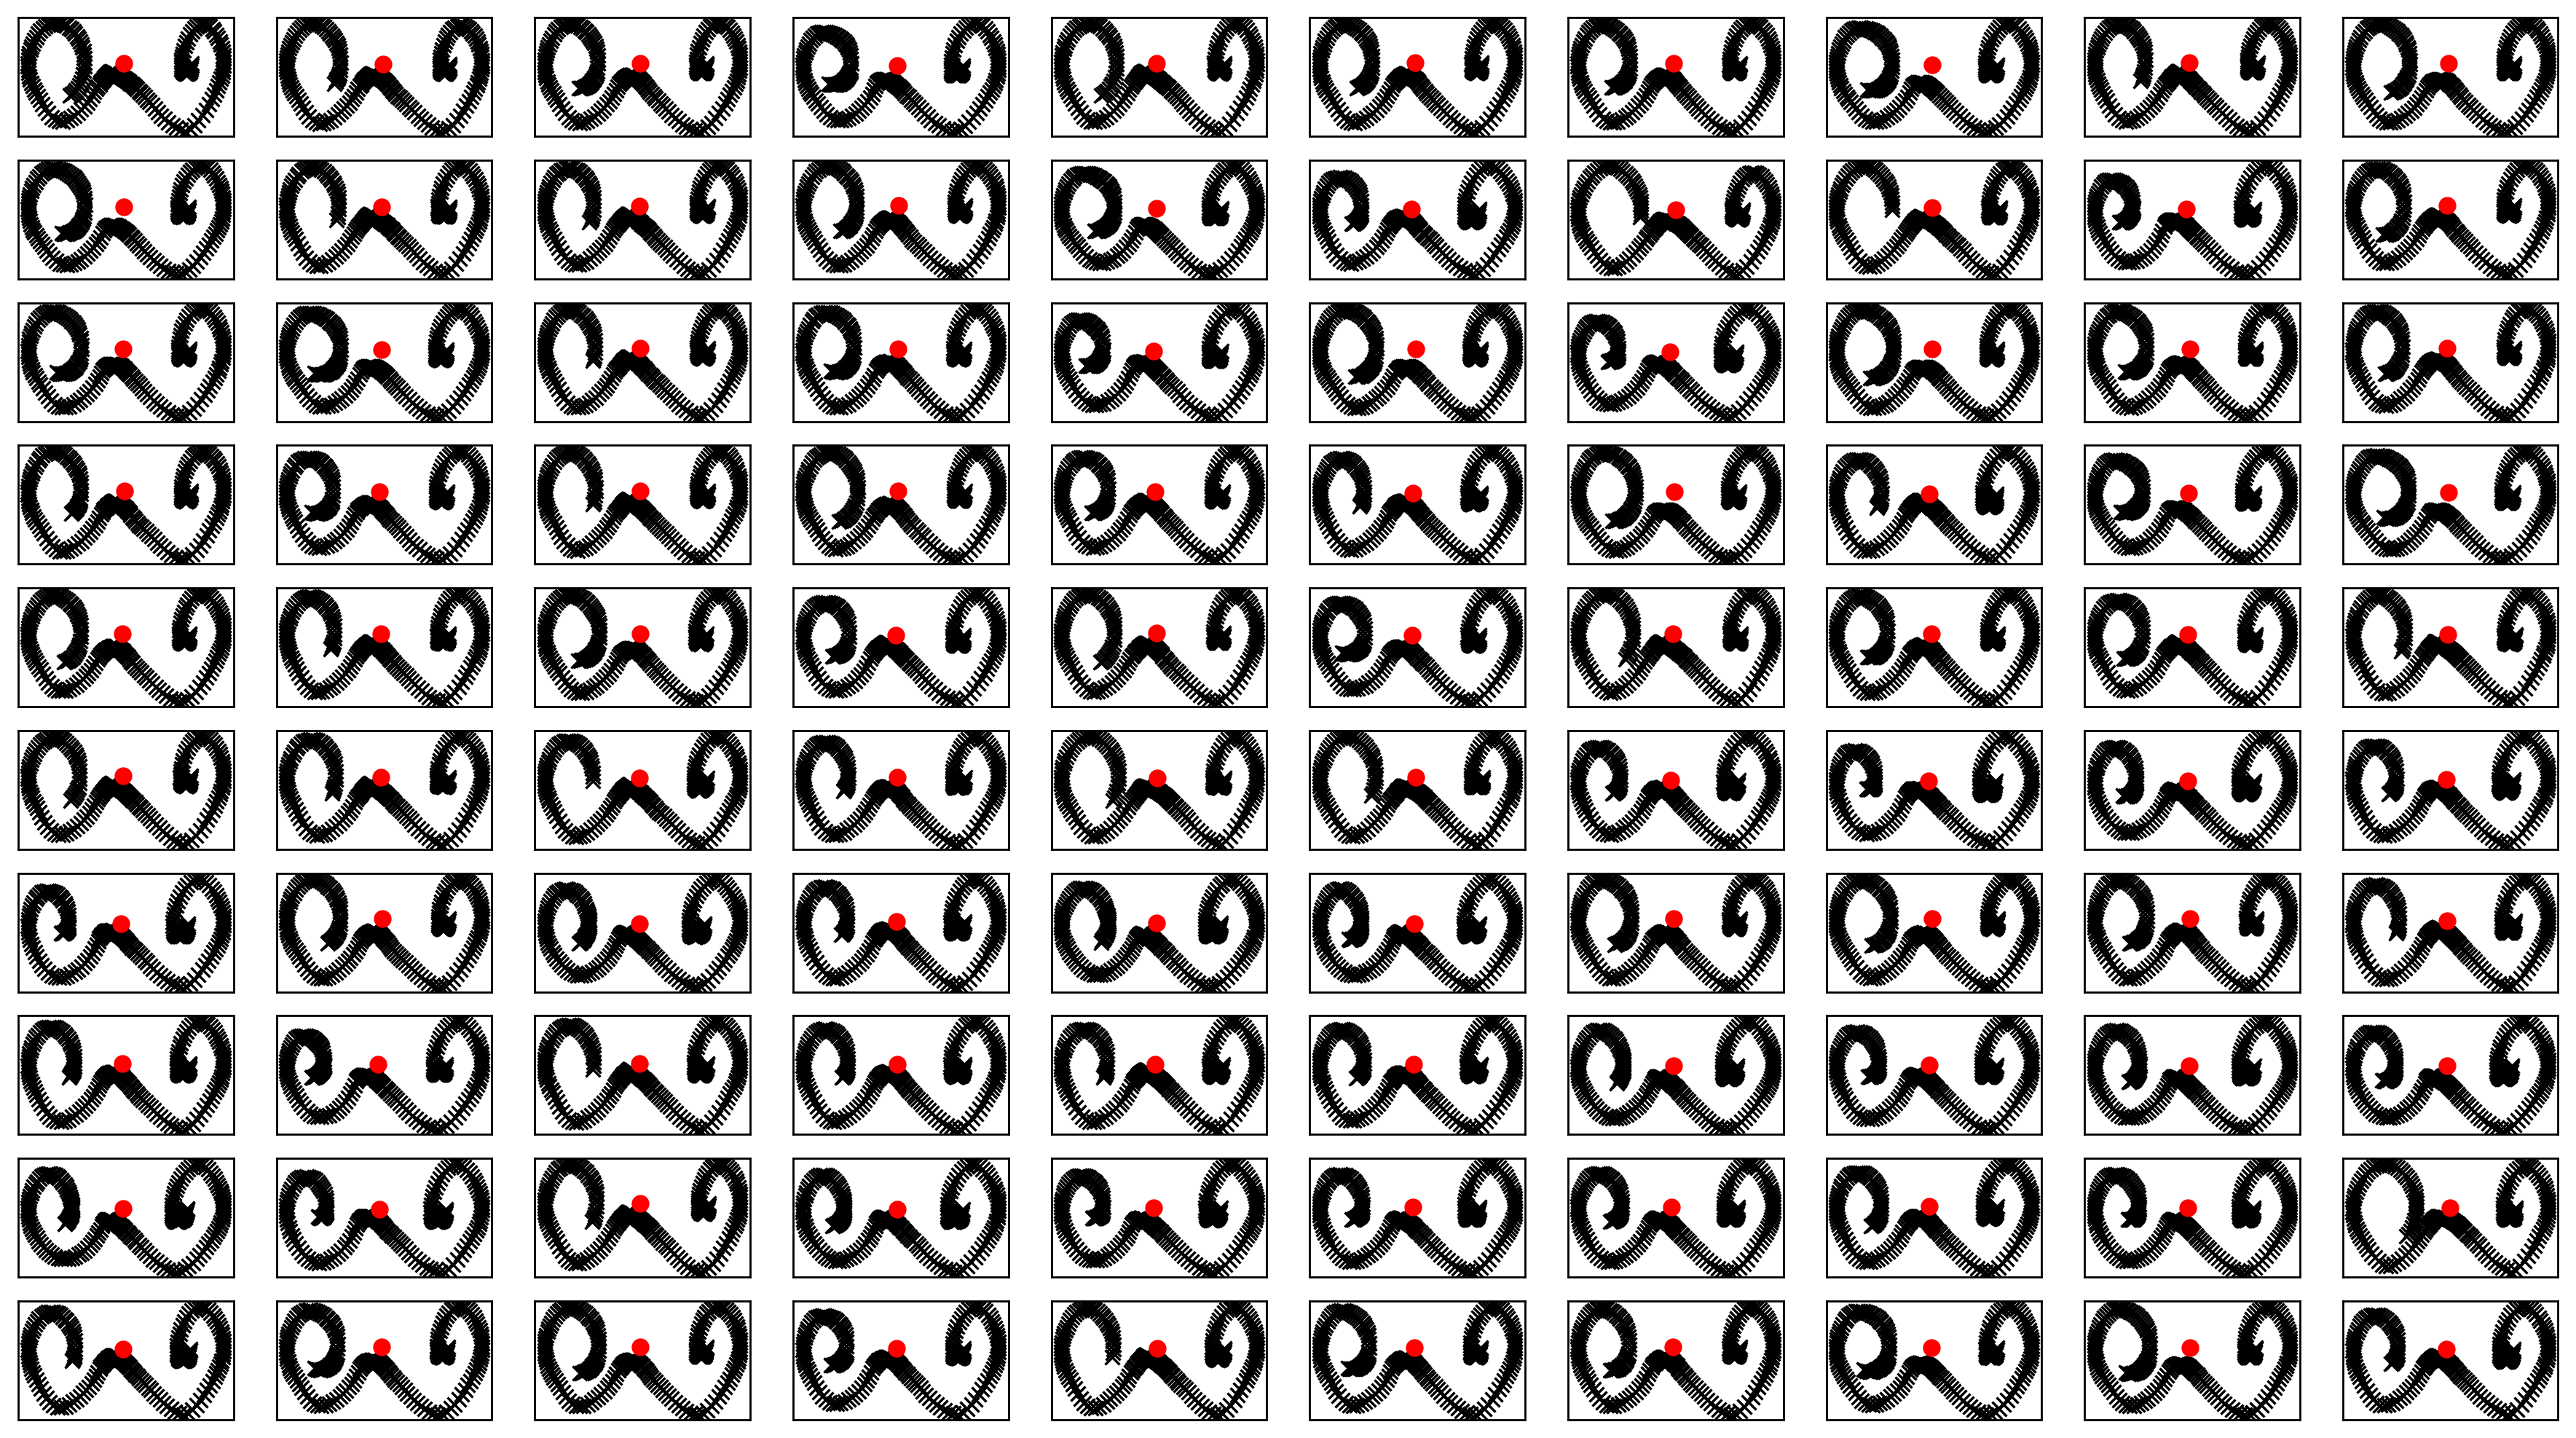

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-22 13:10:18.190998


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.36570  validloss 1.41023±0.00000  bestvalidloss 1.41023  last_update 0
train: iter 1  trainloss 1.31778  validloss 1.32664±0.00000  bestvalidloss 1.32664  last_update 0
train: iter 2  trainloss 1.28069  validloss 1.27595±0.00000  bestvalidloss 1.27595  last_update 0
train: iter 3  trainloss 1.25159  validloss 1.23401±0.00000  bestvalidloss 1.23401  last_update 0
train: iter 4  trainloss 1.21688  validloss 1.19123±0.00000  bestvalidloss 1.19123  last_update 0
train: iter 5  trainloss 1.18040  validloss 1.14776±0.00000  bestvalidloss 1.14776  last_update 0
train: iter 6  trainloss 1.14123  validloss 1.10724±0.00000  bestvalidloss 1.10724  last_update 0
train: iter 7  trainloss 1.10483  validloss 1.07211±0.00000  bestvalidloss 1.07211  last_update 0
train: iter 8  trainloss 1.07946  validloss 1.04241±0.00000  bestvalidloss 1.04241  last_update 0
train: iter 9  trainloss 1.05476  validloss 1.02070±0.00000  bestvalidloss 1.02070  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.77938  validloss 0.84854±0.00000  bestvalidloss 0.82953  last_update 2
train: iter 84  trainloss 0.77966  validloss 0.83126±0.00000  bestvalidloss 0.82953  last_update 3
train: iter 85  trainloss 0.77469  validloss 0.84123±0.00000  bestvalidloss 0.82953  last_update 4
train: iter 86  trainloss 0.77356  validloss 0.84667±0.00000  bestvalidloss 0.82953  last_update 5
train: iter 87  trainloss 0.76652  validloss 0.83701±0.00000  bestvalidloss 0.82953  last_update 6
train: iter 88  trainloss 0.78221  validloss 0.82603±0.00000  bestvalidloss 0.82603  last_update 0
train: iter 89  trainloss 0.76553  validloss 0.83780±0.00000  bestvalidloss 0.82603  last_update 1
train: iter 90  trainloss 0.77481  validloss 0.83023±0.00000  bestvalidloss 0.82603  last_update 2
train: iter 91  trainloss 0.77218  validloss 0.84228±0.00000  bestvalidloss 0.82603  last_update 3
train: iter 92  trainloss 0.76557  validloss 0.82990±0.00000  bestvalidloss 0.82603  last_update 4
train: ite

train: iter 165  trainloss 0.73236  validloss 0.80449±0.00000  bestvalidloss 0.80136  last_update 3
train: iter 166  trainloss 0.72523  validloss 0.80344±0.00000  bestvalidloss 0.80136  last_update 4
train: iter 167  trainloss 0.72210  validloss 0.81167±0.00000  bestvalidloss 0.80136  last_update 5
train: iter 168  trainloss 0.72185  validloss 0.81919±0.00000  bestvalidloss 0.80136  last_update 6
train: iter 169  trainloss 0.71963  validloss 0.83060±0.00000  bestvalidloss 0.80136  last_update 7
train: iter 170  trainloss 0.73337  validloss 0.86754±0.00000  bestvalidloss 0.80136  last_update 8
train: iter 171  trainloss 0.73279  validloss 0.81640±0.00000  bestvalidloss 0.80136  last_update 9
train: iter 172  trainloss 0.71894  validloss 0.84033±0.00000  bestvalidloss 0.80136  last_update 10
train: iter 173  trainloss 0.72209  validloss 0.81036±0.00000  bestvalidloss 0.80136  last_update 11
train: iter 174  trainloss 0.72543  validloss 0.81906±0.00000  bestvalidloss 0.80136  last_update 

train: iter 247  trainloss 0.69723  validloss 0.79267±0.00000  bestvalidloss 0.78304  last_update 29
train: iter 248  trainloss 0.69869  validloss 0.80456±0.00000  bestvalidloss 0.78304  last_update 30
train: iter 249  trainloss 0.70284  validloss 0.79806±0.00000  bestvalidloss 0.78304  last_update 31
train: iter 250  trainloss 0.68712  validloss 0.80181±0.00000  bestvalidloss 0.78304  last_update 32
train: iter 251  trainloss 0.69733  validloss 0.79045±0.00000  bestvalidloss 0.78304  last_update 33
train: iter 252  trainloss 0.69508  validloss 0.78473±0.00000  bestvalidloss 0.78304  last_update 34
train: iter 253  trainloss 0.70102  validloss 0.79655±0.00000  bestvalidloss 0.78304  last_update 35
train: iter 254  trainloss 0.68762  validloss 0.78541±0.00000  bestvalidloss 0.78304  last_update 36
train: iter 255  trainloss 0.69460  validloss 0.80089±0.00000  bestvalidloss 0.78304  last_update 37
train: iter 256  trainloss 0.69346  validloss 0.79682±0.00000  bestvalidloss 0.78304  last_

train: iter 330  trainloss 0.64814  validloss 0.78445±0.00000  bestvalidloss 0.75191  last_update 16
train: iter 331  trainloss 0.64916  validloss 0.75833±0.00000  bestvalidloss 0.75191  last_update 17
train: iter 332  trainloss 0.64512  validloss 0.74424±0.00000  bestvalidloss 0.74424  last_update 0
train: iter 333  trainloss 0.64369  validloss 0.76709±0.00000  bestvalidloss 0.74424  last_update 1
train: iter 334  trainloss 0.65044  validloss 0.75276±0.00000  bestvalidloss 0.74424  last_update 2
train: iter 335  trainloss 0.63938  validloss 0.76048±0.00000  bestvalidloss 0.74424  last_update 3
train: iter 336  trainloss 0.65443  validloss 0.76931±0.00000  bestvalidloss 0.74424  last_update 4
train: iter 337  trainloss 0.63891  validloss 0.76866±0.00000  bestvalidloss 0.74424  last_update 5
train: iter 338  trainloss 0.64094  validloss 0.76188±0.00000  bestvalidloss 0.74424  last_update 6
train: iter 339  trainloss 0.64624  validloss 0.76116±0.00000  bestvalidloss 0.74424  last_update 

train: iter 412  trainloss 0.62355  validloss 0.73684±0.00000  bestvalidloss 0.73573  last_update 32
train: iter 413  trainloss 0.62006  validloss 0.73022±0.00000  bestvalidloss 0.73022  last_update 0
train: iter 414  trainloss 0.61518  validloss 0.75733±0.00000  bestvalidloss 0.73022  last_update 1
train: iter 415  trainloss 0.62589  validloss 0.74807±0.00000  bestvalidloss 0.73022  last_update 2
train: iter 416  trainloss 0.62288  validloss 0.74407±0.00000  bestvalidloss 0.73022  last_update 3
train: iter 417  trainloss 0.62623  validloss 0.75749±0.00000  bestvalidloss 0.73022  last_update 4
train: iter 418  trainloss 0.61582  validloss 0.74760±0.00000  bestvalidloss 0.73022  last_update 5
train: iter 419  trainloss 0.61030  validloss 0.74571±0.00000  bestvalidloss 0.73022  last_update 6
train: iter 420  trainloss 0.61380  validloss 0.75349±0.00000  bestvalidloss 0.73022  last_update 7
train: iter 421  trainloss 0.61515  validloss 0.74677±0.00000  bestvalidloss 0.73022  last_update 8

train: iter 494  trainloss 0.59008  validloss 0.78041±0.00000  bestvalidloss 0.71711  last_update 11
train: iter 495  trainloss 0.59055  validloss 0.74902±0.00000  bestvalidloss 0.71711  last_update 12
train: iter 496  trainloss 0.59626  validloss 0.73014±0.00000  bestvalidloss 0.71711  last_update 13
train: iter 497  trainloss 0.59022  validloss 0.78384±0.00000  bestvalidloss 0.71711  last_update 14
train: iter 498  trainloss 0.59170  validloss 0.74196±0.00000  bestvalidloss 0.71711  last_update 15
train: iter 499  trainloss 0.58736  validloss 0.73306±0.00000  bestvalidloss 0.71711  last_update 16
train: iter 500  trainloss 0.59262  validloss 0.73434±0.00000  bestvalidloss 0.71711  last_update 17
train: iter 501  trainloss 0.59785  validloss 0.74177±0.00000  bestvalidloss 0.71711  last_update 18
train: iter 502  trainloss 0.60106  validloss 0.73870±0.00000  bestvalidloss 0.71711  last_update 19
train: iter 503  trainloss 0.58488  validloss 0.74395±0.00000  bestvalidloss 0.71711  last_

train: iter 577  trainloss 0.58245  validloss 0.72327±0.00000  bestvalidloss 0.70051  last_update 1
train: iter 578  trainloss 0.56006  validloss 0.72581±0.00000  bestvalidloss 0.70051  last_update 2
train: iter 579  trainloss 0.55890  validloss 0.71887±0.00000  bestvalidloss 0.70051  last_update 3
train: iter 580  trainloss 0.56781  validloss 0.73989±0.00000  bestvalidloss 0.70051  last_update 4
train: iter 581  trainloss 0.56625  validloss 0.72565±0.00000  bestvalidloss 0.70051  last_update 5
train: iter 582  trainloss 0.57336  validloss 0.71207±0.00000  bestvalidloss 0.70051  last_update 6
train: iter 583  trainloss 0.56688  validloss 0.71002±0.00000  bestvalidloss 0.70051  last_update 7
train: iter 584  trainloss 0.56516  validloss 0.71842±0.00000  bestvalidloss 0.70051  last_update 8
train: iter 585  trainloss 0.56919  validloss 0.77769±0.00000  bestvalidloss 0.70051  last_update 9
train: iter 586  trainloss 0.57894  validloss 0.73805±0.00000  bestvalidloss 0.70051  last_update 10

train: iter 659  trainloss 0.55573  validloss 0.70291±0.00000  bestvalidloss 0.67194  last_update 22
train: iter 660  trainloss 0.54769  validloss 0.69902±0.00000  bestvalidloss 0.67194  last_update 23
train: iter 661  trainloss 0.54459  validloss 0.69168±0.00000  bestvalidloss 0.67194  last_update 24
train: iter 662  trainloss 0.54627  validloss 0.71560±0.00000  bestvalidloss 0.67194  last_update 25
train: iter 663  trainloss 0.55545  validloss 0.70715±0.00000  bestvalidloss 0.67194  last_update 26
train: iter 664  trainloss 0.55048  validloss 0.68390±0.00000  bestvalidloss 0.67194  last_update 27
train: iter 665  trainloss 0.54944  validloss 0.70341±0.00000  bestvalidloss 0.67194  last_update 28
train: iter 666  trainloss 0.54480  validloss 0.71368±0.00000  bestvalidloss 0.67194  last_update 29
train: iter 667  trainloss 0.54485  validloss 0.70663±0.00000  bestvalidloss 0.67194  last_update 30
train: iter 668  trainloss 0.57015  validloss 0.70032±0.00000  bestvalidloss 0.67194  last_

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.296891817110778
valid_loss:  -6.787175901556014
weight_alpha 1.0 h_min_tilde -11.980572 ell_tilde -4.794948633999825 kappa_tilde 0.0003730506342294097
train_loss:  -5.6809026802063
valid_loss:  -5.673970401000977
weight_alpha 0.1 h_min_tilde -11.980572 ell_tilde -5.679516224365236 kappa_tilde 0.00039837616522424296


In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1108.62839  validloss -1134.12169±0.00000  bestvalidloss -1134.12169  last_update 0
train: iter 1  trainloss -1113.50596  validloss -1081.78319±0.00000  bestvalidloss -1134.12169  last_update 1
train: iter 2  trainloss -1103.27328  validloss -1076.80559±0.00000  bestvalidloss -1134.12169  last_update 2
train: iter 3  trainloss -1120.72344  validloss -1103.01470±0.00000  bestvalidloss -1134.12169  last_update 3
train: iter 4  trainloss -1096.36542  validloss -1107.89277±0.00000  bestvalidloss -1134.12169  last_update 4
train: iter 5  trainloss -1094.28708  validloss -1094.31614±0.00000  bestvalidloss -1134.12169  last_update 5
train: iter 6  trainloss -1105.60529  validloss -1102.20229±0.00000  bestvalidloss -1134.12169  last_update 6
train: iter 7  trainloss -1077.76532  validloss -1108.85271±0.00000  bestvalidloss -1134.12169  last_update 7
train: iter 8  trainloss -1104.70849  validloss -1026.28958±0.00000  bestva

train: iter 73  trainloss -1103.44614  validloss -1018.01196±0.00000  bestvalidloss -1134.12169  last_update 73
train: iter 74  trainloss -1101.80593  validloss -1023.08711±0.00000  bestvalidloss -1134.12169  last_update 74
train: iter 75  trainloss -1094.12853  validloss -1026.70650±0.00000  bestvalidloss -1134.12169  last_update 75
train: iter 76  trainloss -1084.52368  validloss -993.51022±0.00000  bestvalidloss -1134.12169  last_update 76
train: iter 77  trainloss -1071.40823  validloss -990.99507±0.00000  bestvalidloss -1134.12169  last_update 77
train: iter 78  trainloss -1096.98849  validloss -998.56680±0.00000  bestvalidloss -1134.12169  last_update 78
train: iter 79  trainloss -1084.33299  validloss -998.18052±0.00000  bestvalidloss -1134.12169  last_update 79
train: iter 80  trainloss -1061.66513  validloss -933.25263±0.00000  bestvalidloss -1134.12169  last_update 80
train: iter 81  trainloss -1099.65424  validloss -1008.68165±0.00000  bestvalidloss -1134.12169  last_update 

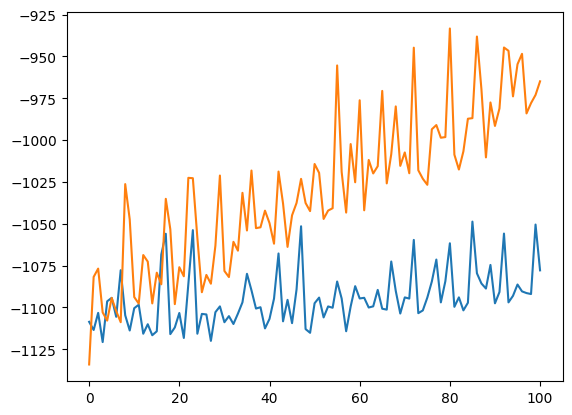

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-22 13:34:06.226052


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.74898  validloss 1.20191±0.00000  bestvalidloss 1.20191  last_update 0
train: iter 1  trainloss 0.67349  validloss 0.70699±0.00000  bestvalidloss 0.70699  last_update 0
train: iter 2  trainloss 0.64785  validloss 0.69207±0.00000  bestvalidloss 0.69207  last_update 0
train: iter 3  trainloss 0.65466  validloss 0.68198±0.00000  bestvalidloss 0.68198  last_update 0
train: iter 4  trainloss 0.63622  validloss 0.68027±0.00000  bestvalidloss 0.68027  last_update 0
train: iter 5  trainloss 0.62876  validloss 0.68354±0.00000  bestvalidloss 0.68027  last_update 1
train: iter 6  trainloss 0.62763  validloss 0.67407±0.00000  bestvalidloss 0.67407  last_update 0
train: iter 7  trainloss 0.62844  validloss 0.66843±0.00000  bestvalidloss 0.66843  last_update 0
train: iter 8  trainloss 0.62315  validloss 0.69899±0.00000  bestvalidloss 0.66843  last_update 1
train: iter 9  trainloss 0.62216  validloss 0.67125±0.00000  bestvalidloss 0.66843  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.57307  validloss 0.63141±0.00000  bestvalidloss 0.63141  last_update 0
train: iter 84  trainloss 0.57343  validloss 0.63712±0.00000  bestvalidloss 0.63141  last_update 1
train: iter 85  trainloss 0.59797  validloss 0.64747±0.00000  bestvalidloss 0.63141  last_update 2
train: iter 86  trainloss 0.57219  validloss 0.65908±0.00000  bestvalidloss 0.63141  last_update 3
train: iter 87  trainloss 0.58946  validloss 0.65913±0.00000  bestvalidloss 0.63141  last_update 4
train: iter 88  trainloss 0.58050  validloss 0.64103±0.00000  bestvalidloss 0.63141  last_update 5
train: iter 89  trainloss 0.56815  validloss 0.66170±0.00000  bestvalidloss 0.63141  last_update 6
train: iter 90  trainloss 0.57794  validloss 0.64199±0.00000  bestvalidloss 0.63141  last_update 7
train: iter 91  trainloss 0.56840  validloss 0.65045±0.00000  bestvalidloss 0.63141  last_update 8
train: iter 92  trainloss 0.57786  validloss 0.65123±0.00000  bestvalidloss 0.63141  last_update 9
train: ite

train: iter 165  trainloss 0.54872  validloss 0.64715±0.00000  bestvalidloss 0.61385  last_update 11
train: iter 166  trainloss 0.54849  validloss 0.62918±0.00000  bestvalidloss 0.61385  last_update 12
train: iter 167  trainloss 0.54165  validloss 0.61492±0.00000  bestvalidloss 0.61385  last_update 13
train: iter 168  trainloss 0.54892  validloss 0.61097±0.00000  bestvalidloss 0.61097  last_update 0
train: iter 169  trainloss 0.54062  validloss 0.61333±0.00000  bestvalidloss 0.61097  last_update 1
train: iter 170  trainloss 0.54704  validloss 0.62941±0.00000  bestvalidloss 0.61097  last_update 2
train: iter 171  trainloss 0.53938  validloss 0.63054±0.00000  bestvalidloss 0.61097  last_update 3
train: iter 172  trainloss 0.55375  validloss 0.66917±0.00000  bestvalidloss 0.61097  last_update 4
train: iter 173  trainloss 0.54295  validloss 0.62956±0.00000  bestvalidloss 0.61097  last_update 5
train: iter 174  trainloss 0.54302  validloss 0.63530±0.00000  bestvalidloss 0.61097  last_update

train: iter 247  trainloss 0.52724  validloss 0.62420±0.00000  bestvalidloss 0.60203  last_update 3
train: iter 248  trainloss 0.52700  validloss 0.62070±0.00000  bestvalidloss 0.60203  last_update 4
train: iter 249  trainloss 0.52386  validloss 0.60429±0.00000  bestvalidloss 0.60203  last_update 5
train: iter 250  trainloss 0.52520  validloss 0.62235±0.00000  bestvalidloss 0.60203  last_update 6
train: iter 251  trainloss 0.52583  validloss 0.60090±0.00000  bestvalidloss 0.60090  last_update 0
train: iter 252  trainloss 0.52880  validloss 0.60774±0.00000  bestvalidloss 0.60090  last_update 1
train: iter 253  trainloss 0.52573  validloss 0.61868±0.00000  bestvalidloss 0.60090  last_update 2
train: iter 254  trainloss 0.53390  validloss 0.61075±0.00000  bestvalidloss 0.60090  last_update 3
train: iter 255  trainloss 0.52659  validloss 0.62070±0.00000  bestvalidloss 0.60090  last_update 4
train: iter 256  trainloss 0.52504  validloss 0.61459±0.00000  bestvalidloss 0.60090  last_update 5


train: iter 329  trainloss 0.51314  validloss 0.63816±0.00000  bestvalidloss 0.59196  last_update 50
train: iter 330  trainloss 0.50970  validloss 0.62480±0.00000  bestvalidloss 0.59196  last_update 51
train: iter 331  trainloss 0.51539  validloss 0.61463±0.00000  bestvalidloss 0.59196  last_update 52
train: iter 332  trainloss 0.51119  validloss 0.62467±0.00000  bestvalidloss 0.59196  last_update 53
train: iter 333  trainloss 0.51784  validloss 0.60409±0.00000  bestvalidloss 0.59196  last_update 54
train: iter 334  trainloss 0.50733  validloss 0.59988±0.00000  bestvalidloss 0.59196  last_update 55
train: iter 335  trainloss 0.51372  validloss 0.62323±0.00000  bestvalidloss 0.59196  last_update 56
train: iter 336  trainloss 0.52007  validloss 0.62084±0.00000  bestvalidloss 0.59196  last_update 57
train: iter 337  trainloss 0.50761  validloss 0.61996±0.00000  bestvalidloss 0.59196  last_update 58
train: iter 338  trainloss 0.50357  validloss 0.62031±0.00000  bestvalidloss 0.59196  last_

train: iter 411  trainloss 0.49622  validloss 0.58923±0.00000  bestvalidloss 0.58831  last_update 20
train: iter 412  trainloss 0.49430  validloss 0.61200±0.00000  bestvalidloss 0.58831  last_update 21
train: iter 413  trainloss 0.49829  validloss 0.59854±0.00000  bestvalidloss 0.58831  last_update 22
train: iter 414  trainloss 0.50037  validloss 0.62191±0.00000  bestvalidloss 0.58831  last_update 23
train: iter 415  trainloss 0.50203  validloss 0.59458±0.00000  bestvalidloss 0.58831  last_update 24
train: iter 416  trainloss 0.49336  validloss 0.59497±0.00000  bestvalidloss 0.58831  last_update 25
train: iter 417  trainloss 0.50198  validloss 0.62007±0.00000  bestvalidloss 0.58831  last_update 26
train: iter 418  trainloss 0.49611  validloss 0.60459±0.00000  bestvalidloss 0.58831  last_update 27
train: iter 419  trainloss 0.49981  validloss 0.60461±0.00000  bestvalidloss 0.58831  last_update 28
train: iter 420  trainloss 0.49374  validloss 0.62662±0.00000  bestvalidloss 0.58831  last_

train: iter 493  trainloss 0.48257  validloss 0.60983±0.00000  bestvalidloss 0.58107  last_update 65
train: iter 494  trainloss 0.48952  validloss 0.59703±0.00000  bestvalidloss 0.58107  last_update 66
train: iter 495  trainloss 0.48535  validloss 0.60371±0.00000  bestvalidloss 0.58107  last_update 67
train: iter 496  trainloss 0.48395  validloss 0.59640±0.00000  bestvalidloss 0.58107  last_update 68
train: iter 497  trainloss 0.48359  validloss 0.60009±0.00000  bestvalidloss 0.58107  last_update 69
train: iter 498  trainloss 0.48725  validloss 0.60631±0.00000  bestvalidloss 0.58107  last_update 70
train: iter 499  trainloss 0.48534  validloss 0.59195±0.00000  bestvalidloss 0.58107  last_update 71
train: iter 500  trainloss 0.48493  validloss 0.59217±0.00000  bestvalidloss 0.58107  last_update 72
train: iter 501  trainloss 0.48347  validloss 0.62612±0.00000  bestvalidloss 0.58107  last_update 73
train: iter 502  trainloss 0.48356  validloss 0.59257±0.00000  bestvalidloss 0.58107  last_

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.410420857340099
valid_loss:  -8.379210588908196
weight_alpha 1.0 h_min_tilde -11.876787 ell_tilde -6.004178803653718 kappa_tilde 0.0004126524991501034
train_loss:  -6.10677052268982
valid_loss:  -5.8291482009887705
weight_alpha 0.1 h_min_tilde -11.876787 ell_tilde -6.05124605834961 kappa_tilde 0.0004143161512340947


In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1231.56213  validloss -1162.34088±0.00000  bestvalidloss -1162.34088  last_update 0
train: iter 1  trainloss -1221.94343  validloss -1174.28018±0.00000  bestvalidloss -1174.28018  last_update 0
train: iter 2  trainloss -1233.85929  validloss -1157.19642±0.00000  bestvalidloss -1174.28018  last_update 1
train: iter 3  trainloss -1217.19487  validloss -1148.56106±0.00000  bestvalidloss -1174.28018  last_update 2
train: iter 4  trainloss -1235.28517  validloss -1162.27008±0.00000  bestvalidloss -1174.28018  last_update 3
train: iter 5  trainloss -1243.08527  validloss -1131.28902±0.00000  bestvalidloss -1174.28018  last_update 4
train: iter 6  trainloss -1227.45484  validloss -1184.48001±0.00000  bestvalidloss -1184.48001  last_update 0
train: iter 7  trainloss -1228.84863  validloss -1163.06288±0.00000  bestvalidloss -1184.48001  last_update 1
train: iter 8  trainloss -1204.85375  validloss -1154.79971±0.00000  bestva

train: iter 73  trainloss -1252.14402  validloss -1096.21936±0.00000  bestvalidloss -1184.48001  last_update 67
train: iter 74  trainloss -1237.45180  validloss -1111.21255±0.00000  bestvalidloss -1184.48001  last_update 68
train: iter 75  trainloss -1242.25576  validloss -1087.50611±0.00000  bestvalidloss -1184.48001  last_update 69
train: iter 76  trainloss -1227.70786  validloss -1093.61313±0.00000  bestvalidloss -1184.48001  last_update 70
train: iter 77  trainloss -1259.41878  validloss -1094.30150±0.00000  bestvalidloss -1184.48001  last_update 71
train: iter 78  trainloss -1268.14578  validloss -1110.50388±0.00000  bestvalidloss -1184.48001  last_update 72
train: iter 79  trainloss -1277.71642  validloss -1121.31089±0.00000  bestvalidloss -1184.48001  last_update 73
train: iter 80  trainloss -1261.17635  validloss -1123.11788±0.00000  bestvalidloss -1184.48001  last_update 74
train: iter 81  trainloss -1262.79318  validloss -1086.61042±0.00000  bestvalidloss -1184.48001  last_up

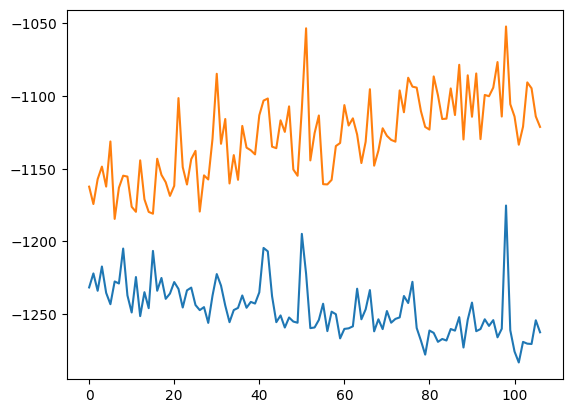

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-22 14:01:11.637499


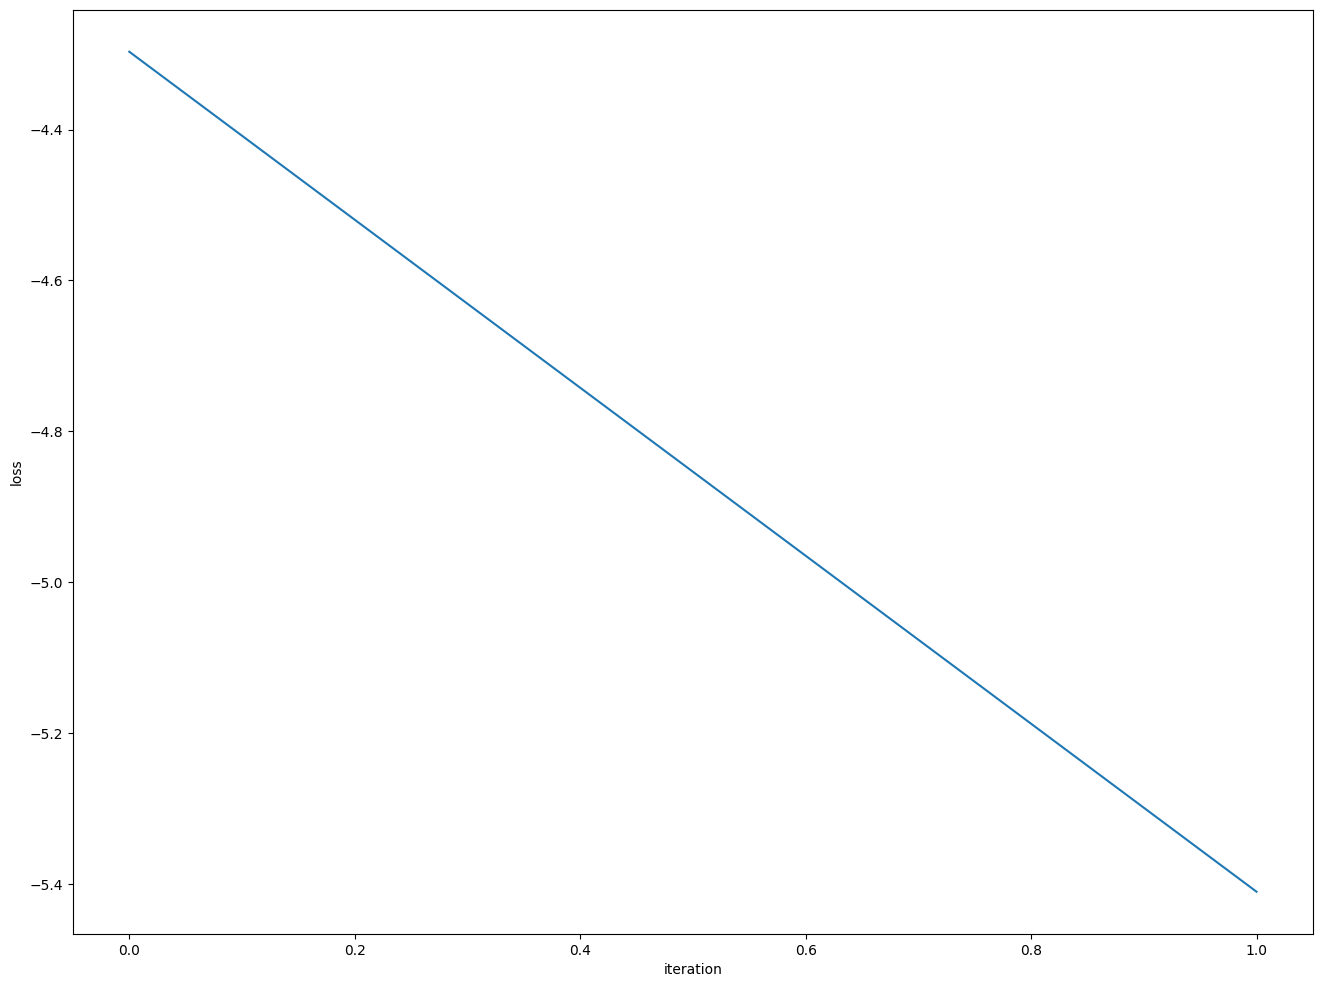

In [25]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(16,12))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

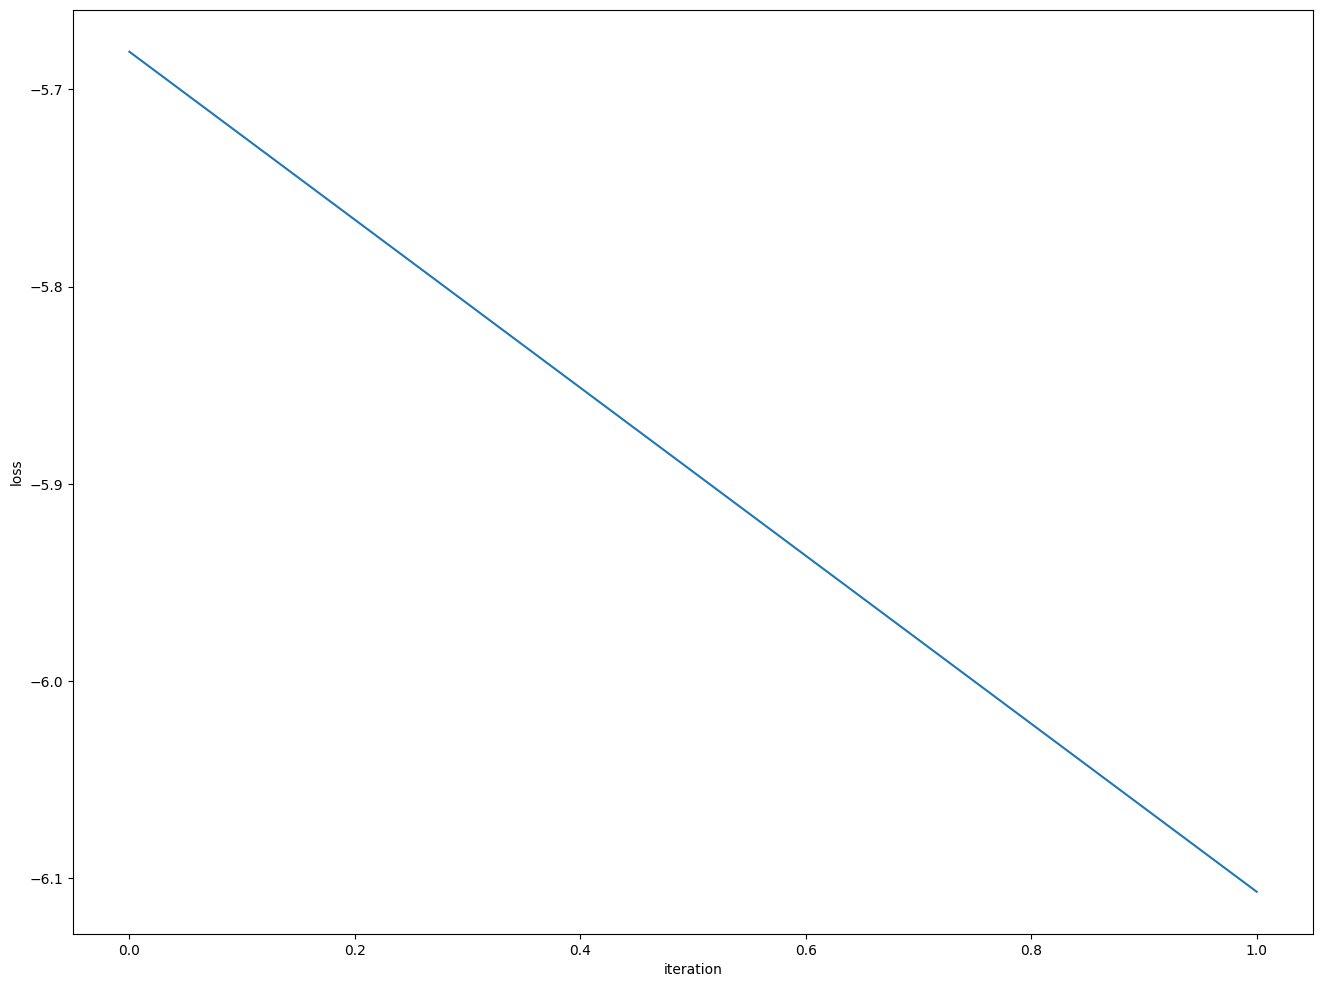

In [26]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [27]:
policy_evaluation_iter=2

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.80553  validloss 1.32773±0.00000  bestvalidloss 1.32773  last_update 0
train: iter 1  trainloss 0.70834  validloss 0.78535±0.00000  bestvalidloss 0.78535  last_update 0
train: iter 2  trainloss 0.69295  validloss 0.72966±0.00000  bestvalidloss 0.72966  last_update 0
train: iter 3  trainloss 0.67779  validloss 0.71293±0.00000  bestvalidloss 0.71293  last_update 0
train: iter 4  trainloss 0.67006  validloss 0.73279±0.00000  bestvalidloss 0.71293  last_update 1
train: iter 5  trainloss 0.66899  validloss 0.71782±0.00000  bestvalidloss 0.71293  last_update 2
train: iter 6  trainloss 0.65932  validloss 0.70774±0.00000  bestvalidloss 0.70774  last_update 0
train: iter 7  trainloss 0.65924  validloss 0.70803±0.00000  bestvalidloss 0.70774  last_update 1
train: iter 8  trainloss 0.65064  validloss 0.71282±0.00000  bestvalidloss 0.70774  last_update 2
train: iter 9  trainloss 0.64979  validloss 0.69671±0.00000  bestvalidloss 0.69671  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.59959  validloss 0.66270±0.00000  bestvalidloss 0.65417  last_update 6
train: iter 84  trainloss 0.59069  validloss 0.67967±0.00000  bestvalidloss 0.65417  last_update 7
train: iter 85  trainloss 0.59250  validloss 0.67057±0.00000  bestvalidloss 0.65417  last_update 8
train: iter 86  trainloss 0.59171  validloss 0.65694±0.00000  bestvalidloss 0.65417  last_update 9
train: iter 87  trainloss 0.59136  validloss 0.65581±0.00000  bestvalidloss 0.65417  last_update 10
train: iter 88  trainloss 0.59009  validloss 0.65767±0.00000  bestvalidloss 0.65417  last_update 11
train: iter 89  trainloss 0.58701  validloss 0.67854±0.00000  bestvalidloss 0.65417  last_update 12
train: iter 90  trainloss 0.59578  validloss 0.65885±0.00000  bestvalidloss 0.65417  last_update 13
train: iter 91  trainloss 0.58756  validloss 0.65924±0.00000  bestvalidloss 0.65417  last_update 14
train: iter 92  trainloss 0.58577  validloss 0.67132±0.00000  bestvalidloss 0.65417  last_update 15
trai

train: iter 165  trainloss 0.57197  validloss 0.64925±0.00000  bestvalidloss 0.64925  last_update 0
train: iter 166  trainloss 0.56955  validloss 0.65753±0.00000  bestvalidloss 0.64925  last_update 1
train: iter 167  trainloss 0.57228  validloss 0.65818±0.00000  bestvalidloss 0.64925  last_update 2
train: iter 168  trainloss 0.56727  validloss 0.65560±0.00000  bestvalidloss 0.64925  last_update 3
train: iter 169  trainloss 0.56473  validloss 0.65743±0.00000  bestvalidloss 0.64925  last_update 4
train: iter 170  trainloss 0.56736  validloss 0.65325±0.00000  bestvalidloss 0.64925  last_update 5
train: iter 171  trainloss 0.56756  validloss 0.66087±0.00000  bestvalidloss 0.64925  last_update 6
train: iter 172  trainloss 0.57019  validloss 0.67793±0.00000  bestvalidloss 0.64925  last_update 7
train: iter 173  trainloss 0.56556  validloss 0.67274±0.00000  bestvalidloss 0.64925  last_update 8
train: iter 174  trainloss 0.56485  validloss 0.66791±0.00000  bestvalidloss 0.64925  last_update 9


train: iter 247  trainloss 0.55392  validloss 0.66419±0.00000  bestvalidloss 0.64891  last_update 60
train: iter 248  trainloss 0.54799  validloss 0.69182±0.00000  bestvalidloss 0.64891  last_update 61
train: iter 249  trainloss 0.55048  validloss 0.65851±0.00000  bestvalidloss 0.64891  last_update 62
train: iter 250  trainloss 0.55345  validloss 0.65498±0.00000  bestvalidloss 0.64891  last_update 63
train: iter 251  trainloss 0.55136  validloss 0.70070±0.00000  bestvalidloss 0.64891  last_update 64
train: iter 252  trainloss 0.54598  validloss 0.68063±0.00000  bestvalidloss 0.64891  last_update 65
train: iter 253  trainloss 0.54637  validloss 0.68259±0.00000  bestvalidloss 0.64891  last_update 66
train: iter 254  trainloss 0.55160  validloss 0.68642±0.00000  bestvalidloss 0.64891  last_update 67
train: iter 255  trainloss 0.55403  validloss 0.66239±0.00000  bestvalidloss 0.64891  last_update 68
train: iter 256  trainloss 0.54794  validloss 0.66843±0.00000  bestvalidloss 0.64891  last_

In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.918605459070205
valid_loss:  -8.462980765914915
weight_alpha 1.0 h_min_tilde -11.993616 ell_tilde -7.227480520439148 kappa_tilde 0.00045805413040687405
train_loss:  -6.806610092544557
valid_loss:  -6.11531480255127
weight_alpha 0.1 h_min_tilde -11.993616 ell_tilde -6.668351034545899 kappa_tilde 0.0004333406046669522


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1335.79671  validloss -1221.89901±0.00000  bestvalidloss -1221.89901  last_update 0
train: iter 1  trainloss -1333.87616  validloss -1229.42780±0.00000  bestvalidloss -1229.42780  last_update 0
train: iter 2  trainloss -1344.77633  validloss -1015.05201±0.00000  bestvalidloss -1229.42780  last_update 1
train: iter 3  trainloss -1352.81015  validloss -1161.98699±0.00000  bestvalidloss -1229.42780  last_update 2
train: iter 4  trainloss -1330.40577  validloss -1241.13893±0.00000  bestvalidloss -1241.13893  last_update 0
train: iter 5  trainloss -1352.00909  validloss -1198.88695±0.00000  bestvalidloss -1241.13893  last_update 1
train: iter 6  trainloss -1355.64107  validloss -1236.25144±0.00000  bestvalidloss -1241.13893  last_update 2
train: iter 7  trainloss -1354.13183  validloss -1187.81751±0.00000  bestvalidloss -1241.13893  last_update 3
train: iter 8  trainloss -1352.71510  validloss -1201.81437±0.00000  bestva

train: iter 74  trainloss -1340.30713  validloss -1171.42384±0.00000  bestvalidloss -1243.10861  last_update 21
train: iter 75  trainloss -1352.82970  validloss -1196.03618±0.00000  bestvalidloss -1243.10861  last_update 22
train: iter 76  trainloss -1361.12010  validloss -1137.42427±0.00000  bestvalidloss -1243.10861  last_update 23
train: iter 77  trainloss -1332.69996  validloss -1203.42806±0.00000  bestvalidloss -1243.10861  last_update 24
train: iter 78  trainloss -1281.61440  validloss -1108.89323±0.00000  bestvalidloss -1243.10861  last_update 25
train: iter 79  trainloss -1354.73164  validloss -1160.08017±0.00000  bestvalidloss -1243.10861  last_update 26
train: iter 80  trainloss -1346.09069  validloss -1162.04737±0.00000  bestvalidloss -1243.10861  last_update 27
train: iter 81  trainloss -1348.84675  validloss -1132.59551±0.00000  bestvalidloss -1243.10861  last_update 28
train: iter 82  trainloss -1286.64287  validloss -1181.52033±0.00000  bestvalidloss -1243.10861  last_up

train: iter 147  trainloss -1313.95633  validloss -1167.04742±0.00000  bestvalidloss -1243.10861  last_update 94
train: iter 148  trainloss -1345.93825  validloss -1182.14975±0.00000  bestvalidloss -1243.10861  last_update 95
train: iter 149  trainloss -1332.52476  validloss -1130.83133±0.00000  bestvalidloss -1243.10861  last_update 96
train: iter 150  trainloss -1359.77534  validloss -1184.72726±0.00000  bestvalidloss -1243.10861  last_update 97
train: iter 151  trainloss -1360.96702  validloss -1169.84400±0.00000  bestvalidloss -1243.10861  last_update 98
train: iter 152  trainloss -1374.02554  validloss -1159.91731±0.00000  bestvalidloss -1243.10861  last_update 99
train: iter 153  trainloss -1363.57654  validloss -1199.84982±0.00000  bestvalidloss -1243.10861  last_update 100
train: fin
penalty_target_min tensor(-12.1774) penalty_target_max tensor(16.8153)


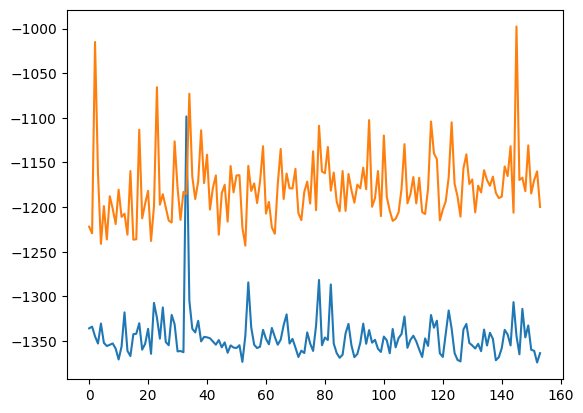

alpha 0.1 default_lr 0.0005


In [32]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [33]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [34]:
print(datetime.datetime.now())

2023-07-22 14:23:52.436367


# Iter 4

In [35]:
policy_evaluation_iter=3

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.79933  validloss 1.20148±0.00000  bestvalidloss 1.20148  last_update 0
train: iter 1  trainloss 0.73792  validloss 0.77797±0.00000  bestvalidloss 0.77797  last_update 0
train: iter 2  trainloss 0.72593  validloss 0.78418±0.00000  bestvalidloss 0.77797  last_update 1
train: iter 3  trainloss 0.70848  validloss 0.77649±0.00000  bestvalidloss 0.77649  last_update 0
train: iter 4  trainloss 0.69903  validloss 0.77799±0.00000  bestvalidloss 0.77649  last_update 1
train: iter 5  trainloss 0.69954  validloss 0.77958±0.00000  bestvalidloss 0.77649  last_update 2
train: iter 6  trainloss 0.69009  validloss 0.81269±0.00000  bestvalidloss 0.77649  last_update 3
train: iter 7  trainloss 0.68555  validloss 0.75837±0.00000  bestvalidloss 0.75837  last_update 0
train: iter 8  trainloss 0.69071  validloss 0.77093±0.00000  bestvalidloss 0.75837  last_update 1
train: iter 9  trainloss 0.67602  validloss 0.77147±0.00000  bestvalidloss 0.75837  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.62155  validloss 0.75289±0.00000  bestvalidloss 0.73302  last_update 2
train: iter 84  trainloss 0.61843  validloss 0.73812±0.00000  bestvalidloss 0.73302  last_update 3
train: iter 85  trainloss 0.61973  validloss 0.73015±0.00000  bestvalidloss 0.73015  last_update 0
train: iter 86  trainloss 0.62091  validloss 0.75549±0.00000  bestvalidloss 0.73015  last_update 1
train: iter 87  trainloss 0.61864  validloss 0.75585±0.00000  bestvalidloss 0.73015  last_update 2
train: iter 88  trainloss 0.61782  validloss 0.73952±0.00000  bestvalidloss 0.73015  last_update 3
train: iter 89  trainloss 0.61745  validloss 0.75567±0.00000  bestvalidloss 0.73015  last_update 4
train: iter 90  trainloss 0.61555  validloss 0.74093±0.00000  bestvalidloss 0.73015  last_update 5
train: iter 91  trainloss 0.61588  validloss 0.74539±0.00000  bestvalidloss 0.73015  last_update 6
train: iter 92  trainloss 0.62030  validloss 0.75503±0.00000  bestvalidloss 0.73015  last_update 7
train: ite

train: iter 165  trainloss 0.60269  validloss 0.73814±0.00000  bestvalidloss 0.72331  last_update 23
train: iter 166  trainloss 0.59879  validloss 0.73112±0.00000  bestvalidloss 0.72331  last_update 24
train: iter 167  trainloss 0.60008  validloss 0.73953±0.00000  bestvalidloss 0.72331  last_update 25
train: iter 168  trainloss 0.59872  validloss 0.72563±0.00000  bestvalidloss 0.72331  last_update 26
train: iter 169  trainloss 0.59955  validloss 0.73932±0.00000  bestvalidloss 0.72331  last_update 27
train: iter 170  trainloss 0.60008  validloss 0.73931±0.00000  bestvalidloss 0.72331  last_update 28
train: iter 171  trainloss 0.59610  validloss 0.73674±0.00000  bestvalidloss 0.72331  last_update 29
train: iter 172  trainloss 0.59540  validloss 0.74149±0.00000  bestvalidloss 0.72331  last_update 30
train: iter 173  trainloss 0.59679  validloss 0.73871±0.00000  bestvalidloss 0.72331  last_update 31
train: iter 174  trainloss 0.59637  validloss 0.74765±0.00000  bestvalidloss 0.72331  last_

train: iter 247  trainloss 0.57853  validloss 0.72687±0.00000  bestvalidloss 0.71773  last_update 7
train: iter 248  trainloss 0.58484  validloss 0.73268±0.00000  bestvalidloss 0.71773  last_update 8
train: iter 249  trainloss 0.58333  validloss 0.73698±0.00000  bestvalidloss 0.71773  last_update 9
train: iter 250  trainloss 0.58194  validloss 0.74610±0.00000  bestvalidloss 0.71773  last_update 10
train: iter 251  trainloss 0.58316  validloss 0.75167±0.00000  bestvalidloss 0.71773  last_update 11
train: iter 252  trainloss 0.58512  validloss 0.73839±0.00000  bestvalidloss 0.71773  last_update 12
train: iter 253  trainloss 0.57883  validloss 0.73691±0.00000  bestvalidloss 0.71773  last_update 13
train: iter 254  trainloss 0.58644  validloss 0.72961±0.00000  bestvalidloss 0.71773  last_update 14
train: iter 255  trainloss 0.58171  validloss 0.73145±0.00000  bestvalidloss 0.71773  last_update 15
train: iter 256  trainloss 0.58445  validloss 0.75114±0.00000  bestvalidloss 0.71773  last_upd

train: iter 330  trainloss 0.57027  validloss 0.73479±0.00000  bestvalidloss 0.71209  last_update 35
train: iter 331  trainloss 0.56859  validloss 0.73864±0.00000  bestvalidloss 0.71209  last_update 36
train: iter 332  trainloss 0.56851  validloss 0.73665±0.00000  bestvalidloss 0.71209  last_update 37
train: iter 333  trainloss 0.56822  validloss 0.74725±0.00000  bestvalidloss 0.71209  last_update 38
train: iter 334  trainloss 0.57197  validloss 0.73174±0.00000  bestvalidloss 0.71209  last_update 39
train: iter 335  trainloss 0.56598  validloss 0.72796±0.00000  bestvalidloss 0.71209  last_update 40
train: iter 336  trainloss 0.57206  validloss 0.73113±0.00000  bestvalidloss 0.71209  last_update 41
train: iter 337  trainloss 0.56752  validloss 0.73279±0.00000  bestvalidloss 0.71209  last_update 42
train: iter 338  trainloss 0.57062  validloss 0.72513±0.00000  bestvalidloss 0.71209  last_update 43
train: iter 339  trainloss 0.56782  validloss 0.73684±0.00000  bestvalidloss 0.71209  last_

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.4805389416277395
valid_loss:  -8.797707000732421
weight_alpha 1.0 h_min_tilde -12.177382 ell_tilde -6.943972553448675 kappa_tilde 0.0004371269911175223
train_loss:  -6.609460438537599
valid_loss:  -5.935243700408936
weight_alpha 0.1 h_min_tilde -12.177382 ell_tilde -6.474617090911867 kappa_tilde 0.00041875234090546563


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1283.18195  validloss -1188.83007±0.00000  bestvalidloss -1188.83007  last_update 0
train: iter 1  trainloss -1283.75263  validloss -1161.00876±0.00000  bestvalidloss -1188.83007  last_update 1
train: iter 2  trainloss -1286.88951  validloss -1123.65174±0.00000  bestvalidloss -1188.83007  last_update 2
train: iter 3  trainloss -1299.12500  validloss -1138.23776±0.00000  bestvalidloss -1188.83007  last_update 3
train: iter 4  trainloss -1286.60649  validloss -1168.28979±0.00000  bestvalidloss -1188.83007  last_update 4
train: iter 5  trainloss -1278.94454  validloss -1140.74327±0.00000  bestvalidloss -1188.83007  last_update 5
train: iter 6  trainloss -1298.75797  validloss -1168.76231±0.00000  bestvalidloss -1188.83007  last_update 6
train: iter 7  trainloss -1277.36890  validloss -1148.52749±0.00000  bestvalidloss -1188.83007  last_update 7
train: iter 8  trainloss -1272.51335  validloss -1130.53926±0.00000  bestva

train: iter 73  trainloss -1266.15722  validloss -1081.03246±0.00000  bestvalidloss -1188.83007  last_update 73
train: iter 74  trainloss -1287.22112  validloss -1149.38188±0.00000  bestvalidloss -1188.83007  last_update 74
train: iter 75  trainloss -1282.31391  validloss -1150.25401±0.00000  bestvalidloss -1188.83007  last_update 75
train: iter 76  trainloss -1287.96409  validloss -1164.93990±0.00000  bestvalidloss -1188.83007  last_update 76
train: iter 77  trainloss -1298.70506  validloss -1141.49256±0.00000  bestvalidloss -1188.83007  last_update 77
train: iter 78  trainloss -1283.28268  validloss -1152.39804±0.00000  bestvalidloss -1188.83007  last_update 78
train: iter 79  trainloss -1243.84704  validloss -1112.16877±0.00000  bestvalidloss -1188.83007  last_update 79
train: iter 80  trainloss -1301.48862  validloss -1156.56522±0.00000  bestvalidloss -1188.83007  last_update 80
train: iter 81  trainloss -1293.32538  validloss -1154.96679±0.00000  bestvalidloss -1188.83007  last_up

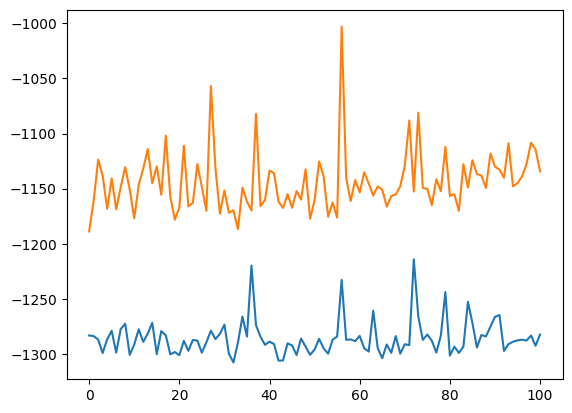

alpha 0.1 default_lr 0.0005


In [40]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [41]:
print(datetime.datetime.now())

2023-07-22 14:46:34.031377


# Iter 5

In [42]:
policy_evaluation_iter=4

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87
predict diverge [-11.24518267 -10.32419511  -0.94899185  -3.07856336] [-0.25520039 -0.04343934 -0.07388912 -0.2711456 ] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 114

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.72491  validloss 1.13410±0.00000  bestvalidloss 1.13410  last_update 0
train: iter 1  trainloss 0.67767  validloss 0.83282±0.00000  bestvalidloss 0.83282  last_update 0
train: iter 2  trainloss 0.66634  validloss 0.79982±0.00000  bestvalidloss 0.79982  last_update 0
train: iter 3  trainloss 0.65591  validloss 0.75286±0.00000  bestvalidloss 0.75286  last_update 0
train: iter 4  trainloss 0.64867  validloss 0.74732±0.00000  bestvalidloss 0.74732  last_update 0
train: iter 5  trainloss 0.64855  validloss 0.73458±0.00000  bestvalidloss 0.73458  last_update 0
train: iter 6  trainloss 0.64200  validloss 0.72613±0.00000  bestvalidloss 0.72613  last_update 0
train: iter 7  trainloss 0.64270  validloss 0.73291±0.00000  bestvalidloss 0.72613  last_update 1
train: iter 8  trainloss 0.64374  validloss 0.72298±0.00000  bestvalidloss 0.72298  last_update 0
train: iter 9  trainloss 0.64056  validloss 0.72292±0.00000  bestvalidloss 0.72292  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.59415  validloss 0.65065±0.00000  bestvalidloss 0.64702  last_update 5
train: iter 84  trainloss 0.59736  validloss 0.65939±0.00000  bestvalidloss 0.64702  last_update 6
train: iter 85  trainloss 0.59241  validloss 0.66039±0.00000  bestvalidloss 0.64702  last_update 7
train: iter 86  trainloss 0.59011  validloss 0.65126±0.00000  bestvalidloss 0.64702  last_update 8
train: iter 87  trainloss 0.59302  validloss 0.66608±0.00000  bestvalidloss 0.64702  last_update 9
train: iter 88  trainloss 0.59304  validloss 0.65513±0.00000  bestvalidloss 0.64702  last_update 10
train: iter 89  trainloss 0.59034  validloss 0.65028±0.00000  bestvalidloss 0.64702  last_update 11
train: iter 90  trainloss 0.58846  validloss 0.67189±0.00000  bestvalidloss 0.64702  last_update 12
train: iter 91  trainloss 0.58815  validloss 0.64954±0.00000  bestvalidloss 0.64702  last_update 13
train: iter 92  trainloss 0.58957  validloss 0.65189±0.00000  bestvalidloss 0.64702  last_update 14
train

train: iter 165  trainloss 0.57434  validloss 0.66283±0.00000  bestvalidloss 0.64702  last_update 87
train: iter 166  trainloss 0.57418  validloss 0.66050±0.00000  bestvalidloss 0.64702  last_update 88
train: iter 167  trainloss 0.57376  validloss 0.66135±0.00000  bestvalidloss 0.64702  last_update 89
train: iter 168  trainloss 0.57269  validloss 0.67300±0.00000  bestvalidloss 0.64702  last_update 90
train: iter 169  trainloss 0.56942  validloss 0.65268±0.00000  bestvalidloss 0.64702  last_update 91
train: iter 170  trainloss 0.57219  validloss 0.65283±0.00000  bestvalidloss 0.64702  last_update 92
train: iter 171  trainloss 0.57160  validloss 0.66463±0.00000  bestvalidloss 0.64702  last_update 93
train: iter 172  trainloss 0.57444  validloss 0.67614±0.00000  bestvalidloss 0.64702  last_update 94
train: iter 173  trainloss 0.57558  validloss 0.65823±0.00000  bestvalidloss 0.64702  last_update 95
train: iter 174  trainloss 0.56807  validloss 0.66550±0.00000  bestvalidloss 0.64702  last_

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.959665341734886
valid_loss:  -8.115960203552246
weight_alpha 1.0 h_min_tilde -12.135849 ell_tilde -7.190924314098359 kappa_tilde 0.00044969717499421735
train_loss:  -6.758636922836304
valid_loss:  -5.982288336944579
weight_alpha 0.1 h_min_tilde -12.135849 ell_tilde -6.603367205657959 kappa_tilde 0.00042514786579790447


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1374.30769  validloss -1192.52491±0.00000  bestvalidloss -1192.52491  last_update 0
train: iter 1  trainloss -1353.34091  validloss -1226.84612±0.00000  bestvalidloss -1226.84612  last_update 0
train: iter 2  trainloss -1382.64781  validloss -1193.04062±0.00000  bestvalidloss -1226.84612  last_update 1
train: iter 3  trainloss -1385.84954  validloss -1163.41732±0.00000  bestvalidloss -1226.84612  last_update 2
train: iter 4  trainloss -1381.15729  validloss -1188.88385±0.00000  bestvalidloss -1226.84612  last_update 3
train: iter 5  trainloss -1366.50160  validloss -1228.31358±0.00000  bestvalidloss -1228.31358  last_update 0
train: iter 6  trainloss -1374.34529  validloss -1212.15341±0.00000  bestvalidloss -1228.31358  last_update 1
train: iter 7  trainloss -1390.24180  validloss -1195.50050±0.00000  bestvalidloss -1228.31358  last_update 2
train: iter 8  trainloss -1379.72937  validloss -1179.24305±0.00000  bestva

train: iter 74  trainloss -1376.63471  validloss -1189.66750±0.00000  bestvalidloss -1229.53856  last_update 42
train: iter 75  trainloss -1339.25907  validloss -1198.78983±0.00000  bestvalidloss -1229.53856  last_update 43
train: iter 76  trainloss -1362.55103  validloss -1162.53445±0.00000  bestvalidloss -1229.53856  last_update 44
train: iter 77  trainloss -1362.96197  validloss -1180.21672±0.00000  bestvalidloss -1229.53856  last_update 45
train: iter 78  trainloss -1365.91984  validloss -1165.86740±0.00000  bestvalidloss -1229.53856  last_update 46
train: iter 79  trainloss -1362.32217  validloss -1175.43783±0.00000  bestvalidloss -1229.53856  last_update 47
train: iter 80  trainloss -1361.99918  validloss -1160.57761±0.00000  bestvalidloss -1229.53856  last_update 48
train: iter 81  trainloss -1348.55666  validloss -1192.24358±0.00000  bestvalidloss -1229.53856  last_update 49
train: iter 82  trainloss -1347.72540  validloss -1153.90733±0.00000  bestvalidloss -1229.53856  last_up

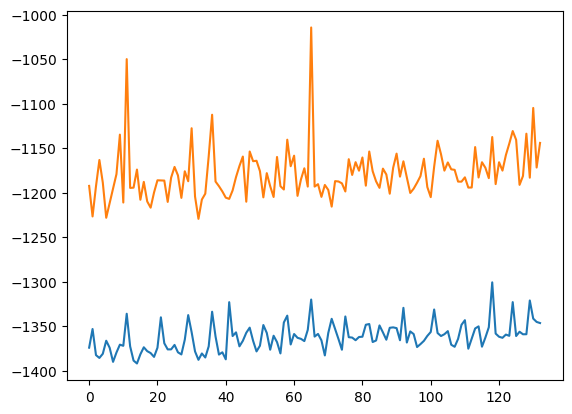

alpha 0.1 default_lr 0.0005


In [47]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [48]:
print(datetime.datetime.now())

2023-07-22 15:09:28.633676


# 評価関数計算

In [49]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [50]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.71960  validloss 0.77608±0.00000  bestvalidloss 0.77608  last_update 0
train: iter 1  trainloss 0.68886  validloss 0.71263±0.00000  bestvalidloss 0.71263  last_update 0
train: iter 2  trainloss 0.67889  validloss 0.70055±0.00000  bestvalidloss 0.70055  last_update 0
train: iter 3  trainloss 0.67436  validloss 0.70282±0.00000  bestvalidloss 0.70055  last_update 1
train: iter 4  trainloss 0.67020  validloss 0.69390±0.00000  bestvalidloss 0.69390  last_update 0
train: iter 5  trainloss 0.66795  validloss 0.70293±0.00000  bestvalidloss 0.69390  last_update 1
train: iter 6  trainloss 0.65995  validloss 0.69209±0.00000  bestvalidloss 0.69209  last_update 0
train: iter 7  trainloss 0.66499  validloss 0.70555±0.00000  bestvalidloss 0.69209  last_update 1
train: iter 8  trainloss 0.66165  validloss 0.69924±0.00000  bestvalidloss 0.69209  last_update 2
train: iter 9  trainloss 0.65385  validloss 0.71147±0.00000  bestvalidloss 0.69209  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.60789  validloss 0.70422±0.00000  bestvalidloss 0.69209  last_update 77
train: iter 84  trainloss 0.60702  validloss 0.70544±0.00000  bestvalidloss 0.69209  last_update 78
train: iter 85  trainloss 0.61116  validloss 0.72109±0.00000  bestvalidloss 0.69209  last_update 79
train: iter 86  trainloss 0.61003  validloss 0.72258±0.00000  bestvalidloss 0.69209  last_update 80
train: iter 87  trainloss 0.61058  validloss 0.71002±0.00000  bestvalidloss 0.69209  last_update 81
train: iter 88  trainloss 0.60920  validloss 0.69568±0.00000  bestvalidloss 0.69209  last_update 82
train: iter 89  trainloss 0.60668  validloss 0.70718±0.00000  bestvalidloss 0.69209  last_update 83
train: iter 90  trainloss 0.60518  validloss 0.70658±0.00000  bestvalidloss 0.69209  last_update 84
train: iter 91  trainloss 0.60872  validloss 0.68986±0.00000  bestvalidloss 0.68986  last_update 0
train: iter 92  trainloss 0.60959  validloss 0.70851±0.00000  bestvalidloss 0.68986  last_update 1
tr

train: iter 165  trainloss 0.59243  validloss 0.72369±0.00000  bestvalidloss 0.68986  last_update 74
train: iter 166  trainloss 0.58628  validloss 0.70853±0.00000  bestvalidloss 0.68986  last_update 75
train: iter 167  trainloss 0.58536  validloss 0.71156±0.00000  bestvalidloss 0.68986  last_update 76
train: iter 168  trainloss 0.59289  validloss 0.70834±0.00000  bestvalidloss 0.68986  last_update 77
train: iter 169  trainloss 0.58840  validloss 0.71281±0.00000  bestvalidloss 0.68986  last_update 78
train: iter 170  trainloss 0.58882  validloss 0.71199±0.00000  bestvalidloss 0.68986  last_update 79
train: iter 171  trainloss 0.58834  validloss 0.71272±0.00000  bestvalidloss 0.68986  last_update 80
train: iter 172  trainloss 0.58710  validloss 0.70842±0.00000  bestvalidloss 0.68986  last_update 81
train: iter 173  trainloss 0.58924  validloss 0.71629±0.00000  bestvalidloss 0.68986  last_update 82
train: iter 174  trainloss 0.58832  validloss 0.70409±0.00000  bestvalidloss 0.68986  last_

([0.7196002116426825,
  0.6888599883764982,
  0.678886391967535,
  0.674363175779581,
  0.6702014351263642,
  0.6679534549824894,
  0.6599469617009163,
  0.664991501159966,
  0.6616469662636518,
  0.6538492722436786,
  0.6535519897937775,
  0.6562891637906432,
  0.6512844586744905,
  0.6494350709952414,
  0.6527098001912236,
  0.6488933512941003,
  0.6445227129384875,
  0.6429325811564922,
  0.6453719628974796,
  0.6451301684603095,
  0.6428246241062879,
  0.6406809527426958,
  0.6426001707091927,
  0.6429675031453371,
  0.6397974167019129,
  0.6363935228437185,
  0.637242017686367,
  0.6323790775611997,
  0.6325327971950173,
  0.6384248802438378,
  0.6344432162120939,
  0.6322452133521438,
  0.6348948296159506,
  0.6278256287798285,
  0.6334802290424705,
  0.6278920305892826,
  0.6325066220015287,
  0.629591739922762,
  0.6288138162344694,
  0.6305895142257214,
  0.6304798910394311,
  0.6246450586244464,
  0.6347463129088282,
  0.6244396481662988,
  0.6289155378937721,
  0.62719510830

In [51]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.645109479427338
valid_loss:  -9.567072324466706
weight_alpha 1.0 h_min_tilde -12.186058 ell_tilde -7.2295020484352115 kappa_tilde 0.0004491692237392124
train_loss:  -6.708702667617798
valid_loss:  -5.973965470886231
weight_alpha 0.1 h_min_tilde -12.186058 ell_tilde -6.561755228271485 kappa_tilde 0.00042166315343092375


In [52]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 242.97831  validloss 269.06725±0.00000  bestvalidloss 269.06725  last_update 0
train: iter 1  trainloss 204.65511  validloss 227.71681±0.00000  bestvalidloss 227.71681  last_update 0
train: iter 2  trainloss 174.14859  validloss 192.73579±0.00000  bestvalidloss 192.73579  last_update 0
train: iter 3  trainloss 147.75228  validloss 165.08468±0.00000  bestvalidloss 165.08468  last_update 0
train: iter 4  trainloss 127.48216  validloss 139.52172±0.00000  bestvalidloss 139.52172  last_update 0
train: iter 5  trainloss 109.51564  validloss 120.89444±0.00000  bestvalidloss 120.89444  last_update 0
train: iter 6  trainloss 94.97017  validloss 105.05703±0.00000  bestvalidloss 105.05703  last_update 0
train: iter 7  trainloss 82.43495  validloss 90.81153±0.00000  bestvalidloss 90.81153  last_update 0
train: iter 8  trainloss 72.15036  validloss 78.85797±0.00000  bestvalidloss 78.85797  last_update 0
train: iter 9  trainloss 63.15175  validloss 69.60753±0.00000  bestvali

train: iter 83  trainloss -0.63301  validloss -1.01047±0.00000  bestvalidloss -1.07856  last_update 18
train: iter 84  trainloss -0.65045  validloss -1.01296±0.00000  bestvalidloss -1.07856  last_update 19
train: iter 85  trainloss -0.64581  validloss -1.05280±0.00000  bestvalidloss -1.07856  last_update 20
train: iter 86  trainloss -0.65432  validloss -0.99119±0.00000  bestvalidloss -1.07856  last_update 21
train: iter 87  trainloss -0.70007  validloss -1.00655±0.00000  bestvalidloss -1.07856  last_update 22
train: iter 88  trainloss -0.64966  validloss -1.02044±0.00000  bestvalidloss -1.07856  last_update 23
train: iter 89  trainloss -0.67519  validloss -1.02410±0.00000  bestvalidloss -1.07856  last_update 24
train: iter 90  trainloss -0.67687  validloss -1.05618±0.00000  bestvalidloss -1.07856  last_update 25
train: iter 91  trainloss -0.65347  validloss -1.03180±0.00000  bestvalidloss -1.07856  last_update 26
train: iter 92  trainloss -0.64699  validloss -0.99057±0.00000  bestvalid

train: iter 171  trainloss -0.68725  validloss -1.12330±0.00000  bestvalidloss -1.17675  last_update 21
train: iter 172  trainloss -0.70387  validloss -1.10248±0.00000  bestvalidloss -1.17675  last_update 22
train: iter 173  trainloss -0.67182  validloss -1.10174±0.00000  bestvalidloss -1.17675  last_update 23
train: iter 174  trainloss -0.66049  validloss -1.07478±0.00000  bestvalidloss -1.17675  last_update 24
train: iter 175  trainloss -0.67428  validloss -1.04145±0.00000  bestvalidloss -1.17675  last_update 25
train: iter 176  trainloss -0.69944  validloss -1.10891±0.00000  bestvalidloss -1.17675  last_update 26
train: iter 177  trainloss -0.70535  validloss -1.07921±0.00000  bestvalidloss -1.17675  last_update 27
train: iter 178  trainloss -0.68157  validloss -1.06356±0.00000  bestvalidloss -1.17675  last_update 28
train: iter 179  trainloss -0.66468  validloss -1.08168±0.00000  bestvalidloss -1.17675  last_update 29
train: iter 180  trainloss -0.71413  validloss -1.09182±0.00000 

In [53]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 2.4546,  1.1758, -4.4488, -2.5390], requires_grad=True)


In [54]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 2.94833  validloss 14.77561±0.00000  bestvalidloss 14.77561  last_update 0
train: iter 1  trainloss 2.21501  validloss 15.55713±0.00000  bestvalidloss 14.77561  last_update 1
train: iter 2  trainloss 2.19157  validloss 16.29937±0.00000  bestvalidloss 14.77561  last_update 2
train: iter 3  trainloss 2.18773  validloss 15.53372±0.00000  bestvalidloss 14.77561  last_update 3
train: iter 4  trainloss 2.17758  validloss 15.77671±0.00000  bestvalidloss 14.77561  last_update 4
train: iter 5  trainloss 2.17637  validloss 15.90386±0.00000  bestvalidloss 14.77561  last_update 5
train: iter 6  trainloss 2.14994  validloss 15.62737±0.00000  bestvalidloss 14.77561  last_update 6
train: iter 7  trainloss 2.16119  validloss 15.99170±0.00000  bestvalidloss 14.77561  last_update 7
train: iter 8  trainloss 2.15691  validloss 16.81941±0.00000  bestvalidloss 14.77561  last_update 8
train: iter 9  trainloss 2.11635  validloss 14.99347±0.00000  bestvalidloss 14.77561  last_update 9


train: iter 81  trainloss 2.03634  validloss 16.88185±0.00000  bestvalidloss 14.28330  last_update 41
train: iter 82  trainloss 2.03003  validloss 15.36613±0.00000  bestvalidloss 14.28330  last_update 42
train: iter 83  trainloss 2.02662  validloss 14.29750±0.00000  bestvalidloss 14.28330  last_update 43
train: iter 84  trainloss 2.02191  validloss 15.66946±0.00000  bestvalidloss 14.28330  last_update 44
train: iter 85  trainloss 2.00879  validloss 17.27309±0.00000  bestvalidloss 14.28330  last_update 45
train: iter 86  trainloss 2.08642  validloss 15.93413±0.00000  bestvalidloss 14.28330  last_update 46
train: iter 87  trainloss 2.00694  validloss 15.94396±0.00000  bestvalidloss 14.28330  last_update 47
train: iter 88  trainloss 2.08964  validloss 15.23403±0.00000  bestvalidloss 14.28330  last_update 48
train: iter 89  trainloss 2.04430  validloss 15.61121±0.00000  bestvalidloss 14.28330  last_update 49
train: iter 90  trainloss 2.03839  validloss 15.66581±0.00000  bestvalidloss 14.28

train: iter 162  trainloss 1.99266  validloss 15.87031±0.00000  bestvalidloss 14.09279  last_update 55
train: iter 163  trainloss 1.99513  validloss 15.49090±0.00000  bestvalidloss 14.09279  last_update 56
train: iter 164  trainloss 2.01137  validloss 16.05950±0.00000  bestvalidloss 14.09279  last_update 57
train: iter 165  trainloss 2.01727  validloss 16.04258±0.00000  bestvalidloss 14.09279  last_update 58
train: iter 166  trainloss 2.02197  validloss 15.16593±0.00000  bestvalidloss 14.09279  last_update 59
train: iter 167  trainloss 2.05282  validloss 16.64217±0.00000  bestvalidloss 14.09279  last_update 60
train: iter 168  trainloss 2.05311  validloss 14.91035±0.00000  bestvalidloss 14.09279  last_update 61
train: iter 169  trainloss 2.02102  validloss 16.48470±0.00000  bestvalidloss 14.09279  last_update 62
train: iter 170  trainloss 2.03317  validloss 15.39984±0.00000  bestvalidloss 14.09279  last_update 63
train: iter 171  trainloss 1.98779  validloss 15.78976±0.00000  bestvalid

In [55]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-3.3574)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-11.8067)


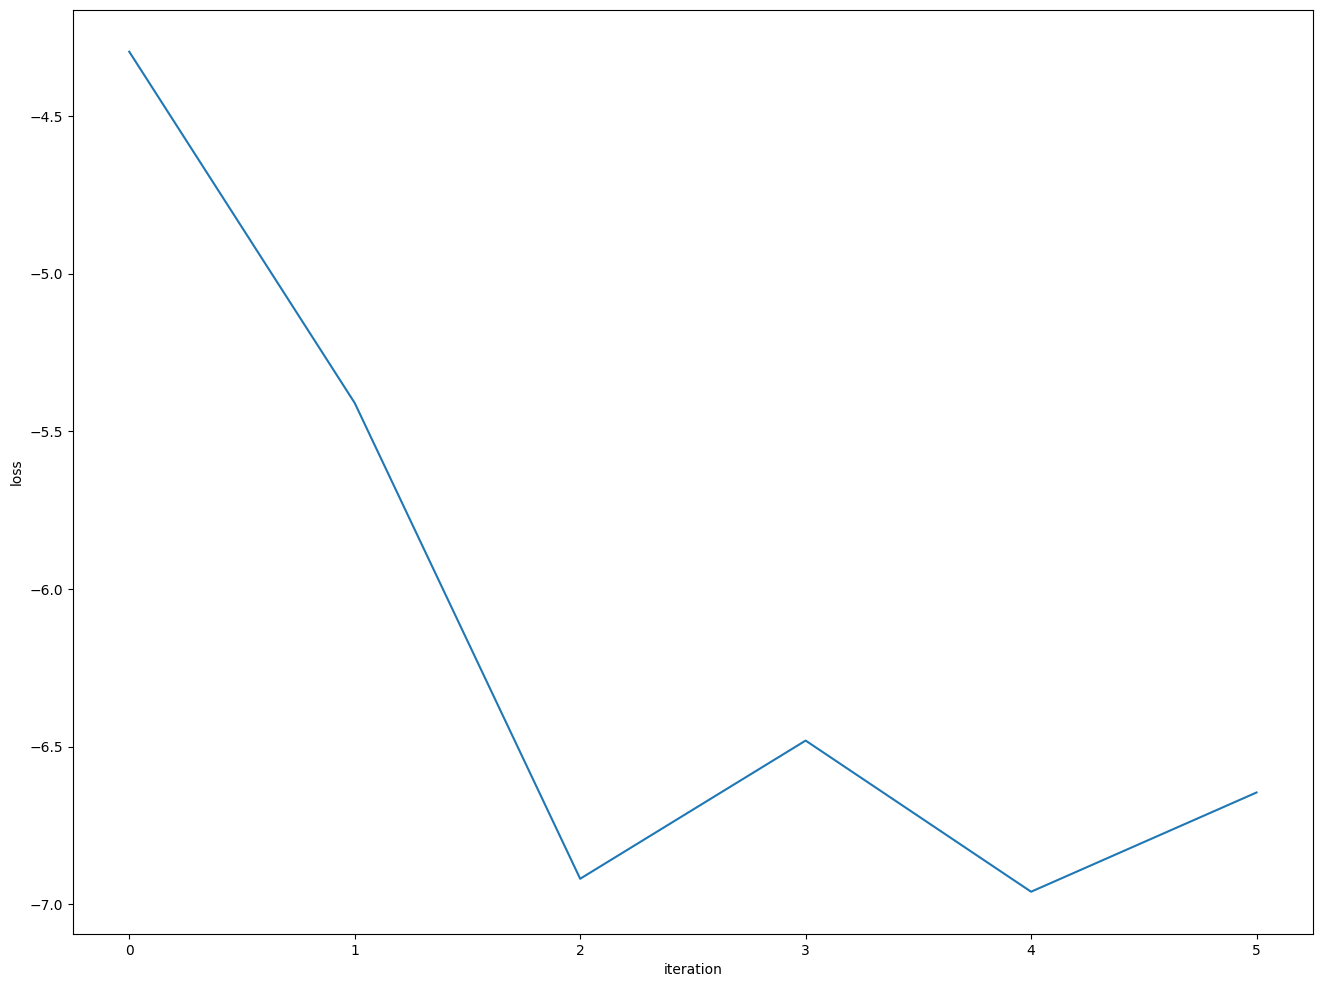

In [56]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

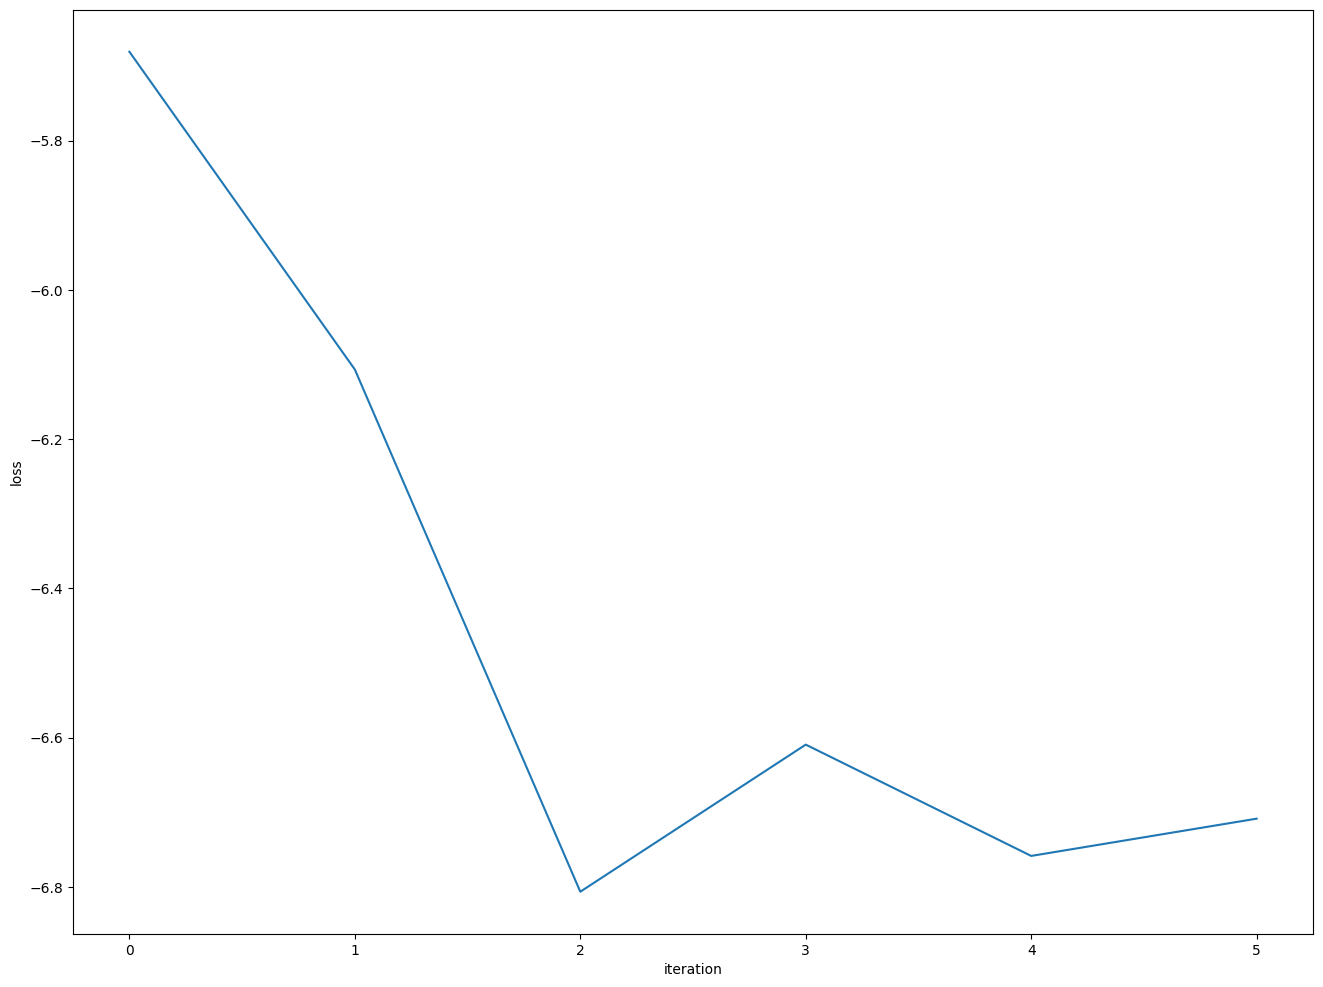

In [57]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")